# Week 9: Fourier Transforms

## Library Imports go here

In [523]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import curve_fit
import csv
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML

## Basic Code for Observables Analysis

<font color = blue>

Begin by copy-pasting the essential code for Crank-Nicholson into this notebook (starting with the generic sparse array code, then the Hamiltonian code, then the T-matrix code, and then the time evolver)

In [526]:
def sparseMatrix(A, B, C, N, s_max):
    '''
    Takes a set of functions and creates a sparse matrix,
    seperating the non-zero values of the matrix and returning them with 
    their corresponding indexes.
    '''
    del_s = s_max / (N+1)
    
    diag_row  = np.array([i for i in range(0, N)])
    diag_col  = np.array([i for i in range(0, N)])
    diag_data = np.array([C(del_s * (i+1)) - ((2 * A(del_s * (i+1))) / del_s**2) for i in range(0, N)])

    up_row  = np.array([i for i in range(0, N-1)])
    up_col  = np.array([i for i in range(1, N)])
    up_data = np.array([(A(del_s * i)/del_s**2) + (B(del_s * i)/(2*del_s)) for i in range(1, N)])

    down_row  = np.array([i for i in range(1, N)])
    down_col  = np.array([i for i in range(0, N-1)])
    down_data = np.array([(A(del_s * (i+1))/del_s**2) - (B(del_s * (i+1))/(2*del_s)) for i in range(1, N)])

    rows = np.concatenate((diag_row, up_row, down_row))
    cols = np.concatenate((diag_col, up_col, down_col))
    data = np.concatenate((diag_data, up_data, down_data))

    return sparse.coo_matrix((data, (rows, cols)), shape=(N, N))

In [527]:
def hamilton(v, x_inf, N):
    def A(x):
        return -1/2
    def B(x):
        return 0.0
    def C(x):
        return v(x)
    return sparseMatrix(A, B, C, N, x_inf)

In [528]:
def tmat(v, x_inf, N, T, M):
    i = 1j
    del_t = T/M
    H = hamilton(v, x_inf, N)
    I = sparse.identity(N)
    first = (I - ((i*del_t)/2)*H)
    second = linalg.inv((I + ((i*del_t)/2)*H))
    return first.dot(second)

In [529]:
def t_evol(psi, v, x_inf, N, T, M):
    del_x = (2 * x_inf) / (N + 1)
    Psi_vec0 = np.array([psi(-x_inf + ((i+1) * del_x)) for i in range(N)], dtype=complex)
    
    Psi_vec = np.zeros((M, N), dtype=complex)
    Psi_vec[0] = Psi_vec0 

    Index = tmat(v, x_inf, N, T, M)

    for n in range(M-1):
        Psi_vec[n+1] = Index @ Psi_vec[n]  

    return Psi_vec

### The Normalization

<font color = blue>
    
We know the normalization integral of the wavefunction

$$
\int_{-\infty}^{\infty} |\Psi(x, t)|^2 \, dx
$$

is going to be approximated as

$$
\Delta_x \, \Big(\vec{\Psi}^{n *}\cdot \vec{\Psi}^{n}\Big)
$$

at time $t_n$.  Write a function that takes the same inputs as your time evolver, and then uses this function to generates the normalization integral at each time $t_n$,  It should output two lists: the times $[t_n]$ and the $[\Delta_x \, \Big(\vec{\Psi}^{n *}\cdot \vec{\Psi}^{n}\Big)]$ values.

In [532]:
def norm(psi, v, x_inf, N, T, M):
    del_x = (2 * x_inf) / (N + 1)
    norms = np.zeros(M, dtype=complex)
    tns = np.zeros(M)
    psi_vec_n = t_evol(psi, v, x_inf, N, T, M)
    for n in range(len(psi_vec_n)): 
        comp_psi_vec_n = np.conjugate(psi_vec_n[n])
        norms[n] = del_x * np.dot(comp_psi_vec_n, psi_vec_n[n])
        norms[n] = norms[n].real
        tns[n] = n
    return tns, norms

### Finite Difference Matrices for Position and Momentum

#### The Momentum Matrix

<font color = blue>
Use the generic matrix making code to create a function which takes as inputs the spatial grid parameters, and outputs the momentum coo-type matrix.

In [536]:
def pmat(x_inf, N):
    def A(x):
        return 0.0
    def B(x):
        i = 1j
        return -i
    def C(x):
        return 0.0
    return sparseMatrix(A, B, C, N, x_inf)

#### The Position Matrix

<font color = blue>
    
Then, do the same to create a position coo-type matrix.

In [539]:
def xmat(x_inf, N):
    def A(x):
        return 0.0
    def B(x):
        return 0.0
    def C(x):
        return x
    return sparseMatrix(A, B, C, N, x_inf)

### Expectation Values and Uncertainties

<font color = blue>

Next, we want to write short functions that will compute for us the integrals we are interested in associated with expectation values and uncertainties. 

#### The Expectation Value of Position

<font color = blue>

Write a function (similar to the normalization function and with the same input structure) which computes the expectation value of position at each time, and returns both the list of times and the list of expectation values.

In [544]:
def x_expect(psi, v, x_inf, N, T, M):
    del_x = (2 * x_inf) / (N + 1)
    expectations = np.zeros(M, dtype=complex)
    tns = np.zeros(M)
    psi_vec_n = t_evol(psi, v, x_inf, N, T, M)
    xmatrix = xmat(x_inf, N)
    
    for n in range(len(psi_vec_n)): 
        comp_psi_vec_n = np.conjugate(psi_vec_n[n])
        xmat_vec = xmatrix @ psi_vec_n[n]
        expectations[n] = del_x * np.dot(comp_psi_vec_n, xmat_vec)
        tns[n] = n
    return tns, expectations

#### The Expectation Value of Momentum

<font color = blue>
Repeat the process for the expectation value of momentum

In [547]:
def p_expect(psi, v, x_inf, N, T, M):
    del_x = (2 * x_inf) / (N + 1)
    expectations = np.zeros(M, dtype=complex)
    tns = np.zeros(M)
    psi_vec_n = t_evol(psi, v, x_inf, N, T, M)
    pmatrix = pmat(x_inf, N)
    # <M>
    for n in range(len(psi_vec_n)): 
        comp_psi_vec_n = np.conjugate(psi_vec_n[n])
        pmat_vec = pmatrix @ psi_vec_n[n]
        expectations[n] = del_x * np.dot(comp_psi_vec_n, pmat_vec)
        tns[n] = n
    return tns, expectations

#### The Uncertainty in Position

<font color = blue>
Repeat the process once again for the uncertainty in position

In [550]:
def x_uncert(psi, v, x_inf, N, T, M):
    del_x = (2 * x_inf) / (N + 1)
    tns = np.zeros(M)
    # <M>^2
    expects_2 = x_expect(psi, v, x_inf, N, T, M)[1]**2
    expects__2 = np.zeros(M, dtype=complex)
    uncerts = np.zeros(M, dtype=complex)
    psi_vec_n = t_evol(psi, v, x_inf, N, T, M)
    xmatrix = xmat(x_inf, N)
    
    # <M^2>
    for n in range(len(psi_vec_n)): 
        comp_psi_vec_n = np.conjugate(psi_vec_n[n])
        xmat_vec = (xmatrix @ xmatrix) @ psi_vec_n[n]
        expects__2[n] = del_x * np.dot(comp_psi_vec_n, xmat_vec)
        tns[n] = n

    for i in range(len(psi_vec_n)):
        uncerts[i] = np.sqrt(expects__2[i] - expects_2[i])
    
    return tns, uncerts

#### The Uncertainty in Momentum

<font color = blue>
And finally, repeat the process one more time for the uncertainty in momentum

In [553]:
def p_uncert(psi, v, x_inf, N, T, M):
    del_x = (2 * x_inf) / (N + 1)
    tns = np.zeros(M)
    # <M>^2
    ts, expects = p_expect(psi, v, x_inf, N, T, M)
    expects_2 = expects**2
    expects__2 = np.zeros(M, dtype=complex)
    uncerts = np.zeros(M, dtype=complex)
    psi_vec_n = t_evol(psi, v, x_inf, N, T, M)
    pmatrix = pmat(x_inf, N)
    
    # <M^2>
    for n in range(len(psi_vec_n)): 
        comp_psi_vec_n = np.conjugate(psi_vec_n[n])
        pmat_vec = (pmatrix @ pmatrix) @ psi_vec_n[n]
        expects__2[n] = del_x * np.dot(comp_psi_vec_n, pmat_vec)
        tns[n] = n

    for i in range(len(psi_vec_n)):
        uncerts[i] = np.sqrt(expects__2[i] - expects_2[i])
    
    return tns, uncerts

<font color = blue>
Now we want to use our code to analyze the evolution of observables in free space, where $V(x) = 0$.  We will use the same two different initial wavefunction shapes as before:

$$
\psi_A(x) = \frac{1}{\pi^{1/4}\sqrt{\sigma}} \, e^{ip_0x} \, e^{-\frac{(x - x_0)^2}{2\sigma^2}}
$$

and

$$
\psi_B(x) = \left\{\begin{array}{rcl} 0 & \mbox{for} & x < x_0 - \sigma \\ \\ \sqrt{\frac{3}{2\sigma^3}} \, (x - x_0 + \sigma) e^{ip_0x} & \mbox{for} & x_0 - \sigma \le x < x_0 \\ \\ -\sqrt{\frac{3}{2\sigma^3}} \, (x - x_0 - \sigma) e^{ip_0x} & \mbox{for} & x_0 \le x < x_0 + \sigma \\ \\ 0 & \mbox{for} & x_0 \le x \end{array}\right.
$$

Both of these wavefunctions are correctly normalized, and are determined by three paramters $\{x_0, p_0, \sigma\}$: the first controls the initial value of $\langle x \rangle$, the second controls the initial value of $\langle p \rangle$, and the third controls the initial uncertainty in both position and momentum.

Below, you will want to recover the four different cases you explored in your previous assignment by making animations of wavefunction evolution -- here you will examine the observable evolution for the same four cases.

In [555]:
# 3rd and 4th (A and B)
x0 = 0
p0 = -1
sig = 1

def psiA(x):
    i = 1j
    first = 1/(np.pi**(1/4)*np.sqrt(sig))
    second = np.exp(i * p0 * x)
    third = np.exp(-((x-x0)**2/(2*sig**2)))
    full = first * second * third
    return full

def psiB(x):
    i = 1j
    if x < (x0 - sig):
        return 0.0
    elif (x0 + sig) <= x:
        return 0.0
    elif (x0 - sig) <= x < x0:
        first = np.sqrt(3/(2*sig**3))*(x-x0+sig)
        second = np.exp(i * p0 * x)
        return first * second
    elif x0 <= x < (x0 + sig):
        first = -np.sqrt(3/(2*sig**3))*(x-x0-sig)
        second = np.exp(i * p0 * x)
        return first * second

### Normalization

<font color = blue>
    
For each of the four cases you made animations of, use your "normalization" function to plot the normalization as a function of time.  Confirm that in each case the wavefunction remains properly normalized at all times.  (Note: it may be helpful to learn how to display multiple plots in a grid)

In [558]:
#norm(psi, v, x_inf, N, T, M)
# 1st and 2nd Cases

x0 = 0
p0 = 1
sig = 1

def v(x):
    return 0.0

def psiA(x):
    i = 1j
    first = 1/(np.pi**(1/4)*np.sqrt(sig))
    second = np.exp(i * p0 * x)
    third = np.exp(-((x-x0)**2/(2*sig**2)))
    full = first * second * third
    return full

def psiB(x):
    i = 1j
    if x < (x0 - sig):
        return 0.0
    elif (x0 + sig) <= x:
        return 0.0
    elif (x0 - sig) <= x < x0:
        first = np.sqrt(3/(2*sig**3))*(x-x0+sig)
        second = np.exp(i * p0 * x)
        return first * second
    elif x0 <= x < (x0 + sig):
        first = -np.sqrt(3/(2*sig**3))*(x-x0-sig)
        second = np.exp(i * p0 * x)
        return first * second

tsA, normsA = norm(psiA, v, 20, 1000, 5, 20)
tsB, normsB = norm(psiB, v, 20, 1000, 5, 20)

In [559]:
# 3rd and 4th Cases

x0 = 0
p0 = -1
sig = 1

def v(x):
    return 0.0

def psiA(x):
    i = 1j
    first = 1/(np.pi**(1/4)*np.sqrt(sig))
    second = np.exp(i * p0 * x)
    third = np.exp(-((x-x0)**2/(2*sig**2)))
    full = first * second * third
    return full

def psiB(x):
    i = 1j
    if x < (x0 - sig):
        return 0.0
    elif (x0 + sig) <= x:
        return 0.0
    elif (x0 - sig) <= x < x0:
        first = np.sqrt(3/(2*sig**3))*(x-x0+sig)
        second = np.exp(i * p0 * x)
        return first * second
    elif x0 <= x < (x0 + sig):
        first = -np.sqrt(3/(2*sig**3))*(x-x0-sig)
        second = np.exp(i * p0 * x)
        return first * second

tsA_neg, normsA_neg = norm(psiA, v, 20, 1000, 5, 20)
tsB_neg, normsB_neg = norm(psiB, v, 20, 1000, 5, 20)

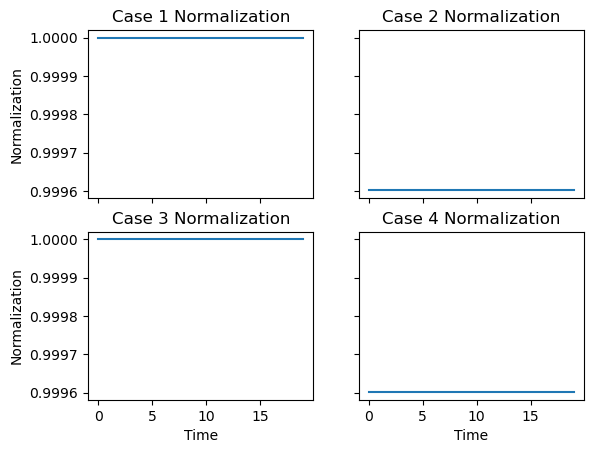

In [560]:
fig, axs = plt.subplots(2, 2, sharex = True, sharey = True)
axs[0, 0].plot(tsA, normsA)
axs[0, 0].set_title('Case 1 Normalization')
axs[0,1].plot(tsB, normsB)
axs[0, 1].set_title('Case 2 Normalization')
axs[1, 0].plot(tsA_neg, normsA_neg)
axs[1, 0].set_title('Case 3 Normalization')
axs[1,1].plot(tsB_neg, normsB_neg)
axs[1, 1].set_title('Case 4 Normalization')

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Normalization')

for ax in axs.flat:
    ax.label_outer()
    
plt.show()

I can confirm that for each case the wavefunction remains properly normalized the entire time T. For each case, the normalization remains at about 1. 

### * Expectation Values for Position and Momentum

<font color = blue>
Now we want to analyze the expectation values $\langle x \rangle$ and $\langle p \rangle$.  Remember that these should satisfy the relationships

$$
\frac{d\langle x \rangle}{dt} = \langle p \rangle, \hspace{.75in} \frac{d\langle p \rangle}{dt} = \left\langle - \frac{dV}{dx}\right\rangle = 0
$$

(they behave roughly like classical position and momentum for a particle with no forces acting on it.)  Create plots of $\langle x \rangle$ and $\langle p \rangle$ as functions of time, again for the four cases you analyzed earlier, and **discuss** what you see.

In [564]:
# 1st and 2nd Cases

x0 = 0
p0 = 1
sig = 1

def v(x):
    return 0.0

def psiA(x):
    i = 1j
    first = 1/(np.pi**(1/4)*np.sqrt(sig))
    second = np.exp(i * p0 * x)
    third = np.exp(-((x-x0)**2/(2*sig**2)))
    full = first * second * third
    return full

def psiB(x):
    i = 1j
    if x < (x0 - sig):
        return 0.0
    elif (x0 + sig) <= x:
        return 0.0
    elif (x0 - sig) <= x < x0:
        first = np.sqrt(3/(2*sig**3))*(x-x0+sig)
        second = np.exp(i * p0 * x)
        return first * second
    elif x0 <= x < (x0 + sig):
        first = -np.sqrt(3/(2*sig**3))*(x-x0-sig)
        second = np.exp(i * p0 * x)
        return first * second

tsA, xexpectsA = x_expect(psiA, v, 20, 1000, 5, 20)
tsA, pexpectsA = p_expect(psiA, v, 20, 1000, 5, 20)

tsB, xexpectsB = x_expect(psiB, v, 20, 1000, 5, 20)
tsB, pexpectsB = p_expect(psiB, v, 20, 1000, 5, 20)

In [565]:
x0 = 0
p0 = -1
sig = 1

def v(x):
    return 0.0

def psiA(x):
    i = 1j
    first = 1/(np.pi**(1/4)*np.sqrt(sig))
    second = np.exp(i * p0 * x)
    third = np.exp(-((x-x0)**2/(2*sig**2)))
    full = first * second * third
    return full

def psiB(x):
    i = 1j
    if x < (x0 - sig):
        return 0.0
    elif (x0 + sig) <= x:
        return 0.0
    elif (x0 - sig) <= x < x0:
        first = np.sqrt(3/(2*sig**3))*(x-x0+sig)
        second = np.exp(i * p0 * x)
        return first * second
    elif x0 <= x < (x0 + sig):
        first = -np.sqrt(3/(2*sig**3))*(x-x0-sig)
        second = np.exp(i * p0 * x)
        return first * second

tsA, xexpectsA_neg = x_expect(psiA, v, 20, 1000, 5, 20)
tsA, pexpectsA_neg = p_expect(psiA, v, 20, 1000, 5, 20)

tsB, xexpectsB_neg = x_expect(psiB, v, 20, 1000, 5, 20)
tsB, pexpectsB_neg = p_expect(psiB, v, 20, 1000, 5, 20)

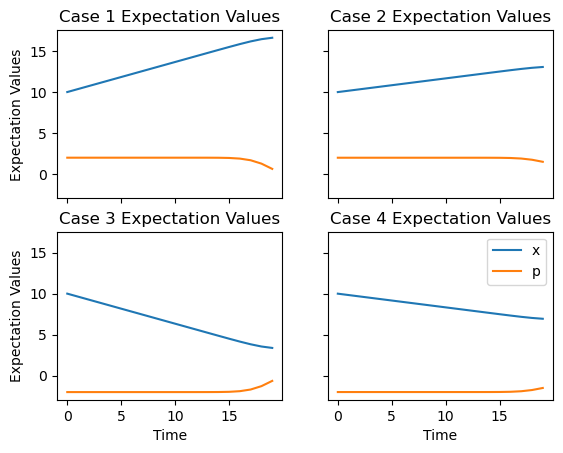

In [566]:


fig, axs = plt.subplots(2, 2, sharex = True, sharey = True)
axs[0, 0].plot(tsA, xexpectsA, label = 'x')
axs[0, 0].plot(tsA, pexpectsA, label = 'p')
axs[0, 0].set_title('Case 1 Expectation Values')
axs[0, 1].plot(tsB, xexpectsB, label = 'x')
axs[0, 1].plot(tsB, pexpectsB, label = 'p')
axs[0, 1].set_title('Case 2 Expectation Values')
axs[1, 0].plot(tsA, xexpectsA_neg, label = 'x')
axs[1, 0].plot(tsA, pexpectsA_neg, label = 'p')
axs[1, 0].set_title('Case 3 Expectation Values')
axs[1, 1].plot(tsB, xexpectsB_neg, label = 'x')
axs[1, 1].plot(tsA, pexpectsB_neg, label = 'p')
axs[1, 1].set_title('Case 4 Expectation Values')

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Expectation Values')

for ax in axs.flat:
    ax.label_outer()
    
plt.legend()
plt.show()

The derivative of the position expectation value with respect to t, should equal the momentum expectation value. This seems to track in the graphs above. I can observe this by seeing the constant slope of the blue lines in some portions relating to the horizontal orange line in those same portions. The other relationship that should be satisfied is that the derivative of the momentum expectation value with respect to t should be 0, I am not exactly sure how to estimate this, but given that the majority of the orange lines are somewhat horizontal throughout T, I can assume they are somewhat constant and therefore making their derivative 0. There was originally an issue with some "wiggles" in the lines (not constant), it seemed that there was an issue with discretization in t_evol, I made M smaller to allow for larger time steps, therefore less error. 

### *Uncertainties in Position and Momentum

<font color = blue>
    
Now repeat the above exercise (including **discussion**) for the uncertainties in position and momentum.  Recall we know two important things about how these quantities should behave: first, momentum is conserved in this system while position isn't, which means $\Delta p$ should be constant, but not $\Delta x$.  Second, the uncertainty principle

$$
\Delta x \, \Delta p \ge \frac{1}{2}
$$

should be satisfied at all times.

In [570]:
# 1st and 2nd Cases

x0 = 0
p0 = 1
sig = 1

def v(x):
    return 0.0

def psiA(x):
    i = 1j
    first = 1/(np.pi**(1/4)*np.sqrt(sig))
    second = np.exp(i * p0 * x)
    third = np.exp(-((x-x0)**2/(2*sig**2)))
    full = first * second * third
    return full

def psiB(x):
    i = 1j
    if x < (x0 - sig):
        return 0.0
    elif (x0 + sig) <= x:
        return 0.0
    elif (x0 - sig) <= x < x0:
        first = np.sqrt(3/(2*sig**3))*(x-x0+sig)
        second = np.exp(i * p0 * x)
        return first * second
    elif x0 <= x < (x0 + sig):
        first = -np.sqrt(3/(2*sig**3))*(x-x0-sig)
        second = np.exp(i * p0 * x)
        return first * second

tsA, xuncertsA = x_uncert(psiA, v, 20, 1000, 5, 20)
tsA, puncertsA = p_uncert(psiA, v, 20, 1000, 5, 20)

tsB, xuncertsB = x_uncert(psiB, v, 20, 1000, 5, 20)
tsB, puncertsB = p_uncert(psiB, v, 20, 1000, 5, 20)

In [571]:
x0 = 0
p0 = -1
sig = 1

def v(x):
    return 0.0

def psiA(x):
    i = 1j
    first = 1/(np.pi**(1/4)*np.sqrt(sig))
    second = np.exp(i * p0 * x)
    third = np.exp(-((x-x0)**2/(2*sig**2)))
    full = first * second * third
    return full

def psiB(x):
    i = 1j
    if x < (x0 - sig):
        return 0.0
    elif (x0 + sig) <= x:
        return 0.0
    elif (x0 - sig) <= x < x0:
        first = np.sqrt(3/(2*sig**3))*(x-x0+sig)
        second = np.exp(i * p0 * x)
        return first * second
    elif x0 <= x < (x0 + sig):
        first = -np.sqrt(3/(2*sig**3))*(x-x0-sig)
        second = np.exp(i * p0 * x)
        return first * second

tsA, xuncertsA_neg = x_uncert(psiA, v, 20, 1000, 5, 20)
tsA, puncertsA_neg = p_uncert(psiA, v, 20, 1000, 5, 20)

tsB, xuncertsB_neg = x_uncert(psiB, v, 20, 1000, 5, 20)
tsB, puncertsB_neg = p_uncert(psiB, v, 20, 1000, 5, 20)

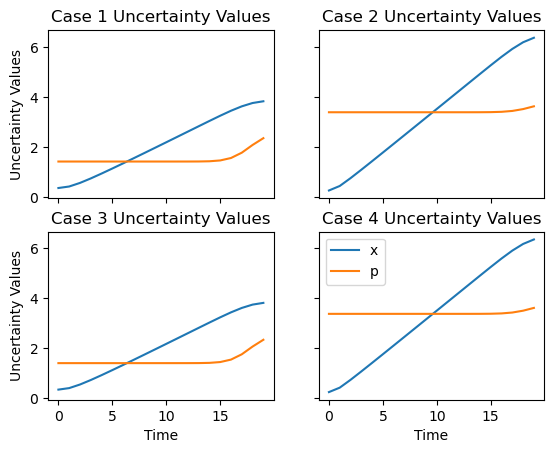

In [572]:
fig, axs = plt.subplots(2, 2, sharex = True, sharey = True)
axs[0, 0].plot(tsA, xuncertsA, label = 'x')
axs[0, 0].plot(tsA, puncertsA, label = 'p')
axs[0, 0].set_title('Case 1 Uncertainty Values')
axs[0, 1].plot(tsB, xuncertsB, label = 'x')
axs[0, 1].plot(tsB, puncertsB, label = 'p')
axs[0, 1].set_title('Case 2 Uncertainty Values')
axs[1, 0].plot(tsA, xuncertsA_neg, label = 'x')
axs[1, 0].plot(tsA, puncertsA_neg, label = 'p')
axs[1, 0].set_title('Case 3 Uncertainty Values')
axs[1, 1].plot(tsB, xuncertsB_neg, label = 'x')
axs[1, 1].plot(tsA, puncertsB_neg, label = 'p')
axs[1, 1].set_title('Case 4 Uncertainty Values')

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Uncertainty Values')

for ax in axs.flat:
    ax.label_outer()
    
plt.legend()
plt.show()

These subplots seem to prove the point that $\Delta p$ is constant while $\Delta x$ is not. This shows that $\Delta x \Delta p \geq \frac{1}{2}$

## * Observables in the SHO Potential

<font color = blue>
Another classic potential to explore is the SHO potential, which we can non-dimensionalize to be

$$
V(x) = \frac{1}{2}x^2
$$

We want to repeat the analysis we just performed for "free space" using this potential.  This time, we will use just the initial Gaussian wavefunction,

$$
\psi_A(x) = \frac{1}{\pi^{1/4}\sqrt{\sigma}} \, e^{ip_0x} \, e^{-\frac{(x - x_0)^2}{2\sigma^2}}
$$

and we will focus on the three cases

$$
x_0 = 0, \ p_0 = 0, \ \sigma = 1
$$

$$
x_0 = 1, \ p_0 = 0, \ \sigma = 1
$$

$$
x_0 = 0, \ p_0 = 1, \ \sigma = 1
$$

In each of these cases you will find the grid parameter choices

$$
x_{\infty} = 10, \ N = 1000, \ T = 20, \ M = 200
$$

to be appropriate.

It will also be helpful for you to know that the first of these cases actually corresponds to an *energy eigenstate* of the quantum SHO system.

### Normalization

<font color = blue>
    
For each of the three cases, use your "normalization" function to plot the normalization as a function of time.  Confirm that in each case the wavefunction remains properly normalized at all times.

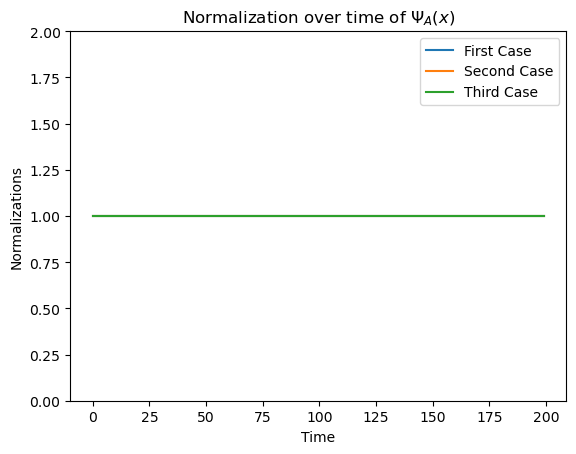

In [578]:
x0 = 0
p0 = 0
sig = 1

def psiA(x):
    i = 1j
    first = 1/(np.pi**(1/4)*np.sqrt(sig))
    second = np.exp(i * p0 * x)
    third = np.exp(-((x-x0)**2/(2*sig**2)))
    full = first * second * third
    return full

def v(x):
    return (1/2)*x**2
    
#First Case
#t_evol(psi, v, x_inf, N, T, M)
tn, norms1 = norm(psiA, v, 10, 1000, 20, 200)

x0 = 1
p0 = 0
sig = 1

def psiA(x):
    i = 1j
    first = 1/(np.pi**(1/4)*np.sqrt(sig))
    second = np.exp(i * p0 * x)
    third = np.exp(-((x-x0)**2/(2*sig**2)))
    full = first * second * third
    return full

def v(x):
    return (1/2)*x**2
    
#second Case
#t_evol(psi, v, x_inf, N, T, M)
tn, norms2 = norm(psiA, v, 10, 1000, 20, 200)

x0 = 0
p0 = 1
sig = 1

def psiA(x):
    i = 1j
    first = 1/(np.pi**(1/4)*np.sqrt(sig))
    second = np.exp(i * p0 * x)
    third = np.exp(-((x-x0)**2/(2*sig**2)))
    full = first * second * third
    return full

def v(x):
    return (1/2)*x**2
    
#third Case
#t_evol(psi, v, x_inf, N, T, M)
tn, norms3 = norm(psiA, v, 10, 1000, 20, 200)

plt.plot(tn, norms1, label = 'First Case')
plt.plot(tn, norms2, label = 'Second Case')
plt.plot(tn, norms3, label = 'Third Case')
plt.ylim(0,2)
plt.xlabel('Time')
plt.ylabel('Normalizations')
plt.title(r'Normalization over time of $\Psi_A(x)$')
    
plt.legend()
plt.show()

I can confirm that the norm of the wavefunction remains at 1 the entire time for all cases. Feel free to take out the y-axis limit to see how it changes over very small periods of time. 

### * Expectation Values for Position and Momentum

<font color = blue>
Now we want to analyze the expectation values $\langle x \rangle$ and $\langle p \rangle$.  Remember that these should satisfy the relationships

$$
\frac{d\langle x \rangle}{dt} = \langle p \rangle, \hspace{.75in} \frac{d\langle p \rangle}{dt} = \left\langle - \frac{dV}{dx}\right\rangle = 0
$$

(they behave roughly like classical position and momentum for a particle with no forces acting on it.)  Create plots of $\langle x \rangle$ and $\langle p \rangle$ as functions of time, again for the four cases you analyzed earlier, and **discuss** the results.

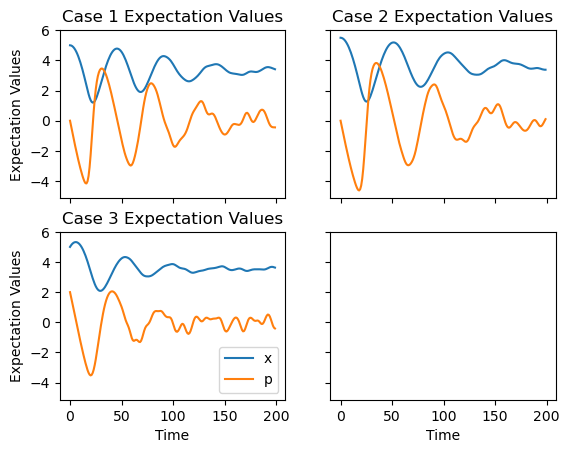

In [582]:
x0 = 0
p0 = 0
sig = 1

def psiA(x):
    i = 1j
    first = 1/(np.pi**(1/4)*np.sqrt(sig))
    second = np.exp(i * p0 * x)
    third = np.exp(-((x-x0)**2/(2*sig**2)))
    full = first * second * third
    return full

def v(x):
    return (1/2)*x**2
    
#First Case
#t_evol(psi, v, x_inf, N, T, M)
tn, expects1x = x_expect(psiA, v, 10, 1000, 20, 200)
tn, expects1p = p_expect(psiA, v, 10, 1000, 20, 200)

x0 = 1
p0 = 0
sig = 1

def psiA(x):
    i = 1j
    first = 1/(np.pi**(1/4)*np.sqrt(sig))
    second = np.exp(i * p0 * x)
    third = np.exp(-((x-x0)**2/(2*sig**2)))
    full = first * second * third
    return full

def v(x):
    return (1/2)*x**2
    
#second Case
#t_evol(psi, v, x_inf, N, T, M)
tn, expects2x = x_expect(psiA, v, 10, 1000, 20, 200)
tn, expects2p = p_expect(psiA, v, 10, 1000, 20, 200)

x0 = 0
p0 = 1
sig = 1

def psiA(x):
    i = 1j
    first = 1/(np.pi**(1/4)*np.sqrt(sig))
    second = np.exp(i * p0 * x)
    third = np.exp(-((x-x0)**2/(2*sig**2)))
    full = first * second * third
    return full

def v(x):
    return (1/2)*x**2
    
#third Case
#t_evol(psi, v, x_inf, N, T, M)
tn, expects3x = x_expect(psiA, v, 10, 1000, 20, 200)
tn, expects3p = p_expect(psiA, v, 10, 1000, 20, 200)

fig, axs = plt.subplots(2, 2, sharex = True, sharey = True)
axs[0, 0].plot(tn, expects1x, label = 'x')
axs[0, 0].plot(tn, expects1p, label = 'p')
axs[0, 0].set_title('Case 1 Expectation Values')
axs[0, 1].plot(tn, expects2x, label = 'x')
axs[0, 1].plot(tn, expects2p, label = 'p')
axs[0, 1].set_title('Case 2 Expectation Values')
axs[1, 0].plot(tn, expects3x, label = 'x')
axs[1, 0].plot(tn, expects3p, label = 'p')
axs[1, 0].set_title('Case 3 Expectation Values')
axs[1,0].legend()
for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Expectation Values')

for ax in axs.flat:
    ax.label_outer()
    
plt.show()

The plots above show the position and momentum over time. The third case shows the momentum and how it evolves with p=0. The first plot has a x0 value of 1, so it starts at a positive x value. 

### * Uncertainties in Position and Momentum

<font color = blue>
    
Now create graphs of $\Delta x$ and $\Delta p$ vs. t for each of the three cases.  This time, also create an explicit graph of $\Delta x \, \Delta p$ as a function of time for each case, so that you can check the uncertainty principle is satisfied.  **Discuss** the results.

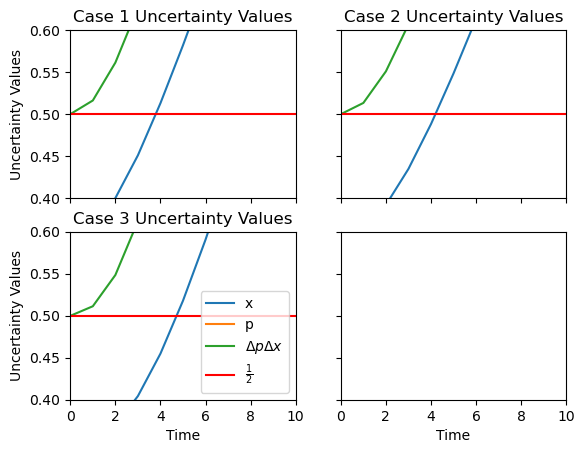

In [586]:
x0 = 0
p0 = 0
sig = 1

def psiA(x):
    i = 1j
    first = 1/(np.pi**(1/4)*np.sqrt(sig))
    second = np.exp(i * p0 * x)
    third = np.exp(-((x-x0)**2/(2*sig**2)))
    full = first * second * third
    return full

def v(x):
    return (1/2)*x**2
    
#First Case
#t_evol(psi, v, x_inf, N, T, M)
tn, uncerts1x = x_uncert(psiA, v, 10, 1000, 20, 200)
tn, uncerts1p = p_uncert(psiA, v, 10, 1000, 20, 200)

x0 = 1
p0 = 0
sig = 1

def psiA(x):
    i = 1j
    first = 1/(np.pi**(1/4)*np.sqrt(sig))
    second = np.exp(i * p0 * x)
    third = np.exp(-((x-x0)**2/(2*sig**2)))
    full = first * second * third
    return full

def v(x):
    return (1/2)*x**2
    
#second Case
#t_evol(psi, v, x_inf, N, T, M)
tn, uncerts2x = x_uncert(psiA, v, 10, 1000, 20, 200)
tn, uncerts2p = p_uncert(psiA, v, 10, 1000, 20, 200)

x0 = 0
p0 = 1
sig = 1

def psiA(x):
    i = 1j
    first = 1/(np.pi**(1/4)*np.sqrt(sig))
    second = np.exp(i * p0 * x)
    third = np.exp(-((x-x0)**2/(2*sig**2)))
    full = first * second * third
    return full

def v(x):
    return (1/2)*x**2
    
#third Case
#t_evol(psi, v, x_inf, N, T, M)
tn, uncerts3x = x_uncert(psiA, v, 10, 1000, 20, 200)
tn, uncerts3p = p_uncert(psiA, v, 10, 1000, 20, 200)

fig, axs = plt.subplots(2, 2, sharex = True, sharey = True)
axs[0, 0].plot(tn, uncerts1x, label = 'x')
axs[0, 0].plot(tn, uncerts1p, label = 'p')
axs[0, 0].plot(tn, uncerts1p*uncerts1x)
axs[0, 0].axhline(y=.5, color = 'r')
axs[0, 0].set_title('Case 1 Uncertainty Values')
axs[0, 1].plot(tn, uncerts2x, label = 'x')
axs[0, 1].plot(tn, uncerts2p, label = 'p')
axs[0, 1].plot(tn, uncerts2p*uncerts2x)
axs[0, 1].axhline(y=.5, color = 'r')
axs[0, 1].set_title('Case 2 Uncertainty Values')
axs[1, 0].plot(tn, uncerts3x, label = 'x')
axs[1, 0].plot(tn, uncerts3p, label = 'p')
axs[1, 0].plot(tn, uncerts3p*uncerts3x, label = r'$\Delta p \Delta x$')
axs[1, 0].axhline(y=.5, color = 'r', label = r'$\frac{1}{2}$')

# CHECK FOR SATISFACTION OF UNCERTAINTY PRINCIPLE
axs[0,0].set_ylim(.4,.6) 
axs[0,0].set_xlim(0, 10) 

axs[1, 0].set_title('Case 3 Uncertainty Values')
axs[1,0].legend()
for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Uncertainty Values')

for ax in axs.flat:
    ax.label_outer()
    
plt.show()

The graphs above show the positional and momentum uncertainties as the wavefunction evolves over time. I have zoomed in on the $y=\frac{1}{2}$ value to check if the product of the two uncertainties is greater than $\frac{1}{2}$, which it is.

## A Basic Fourier Transform Function

### The Code

<font color = blue>
Construct a function that will implement the basic Fourier transform of a discrete data set:

$$
P_k = \sum_{j = 0}^{N-1} p_je^{2\pi ijk/N}, \hspace{.75in} k = 0, 1, 2, \dots, N-1
$$

Your function should take as input a list of discrete values $[p_0, p_1, \dots, p_{N-1}]$ and a time step $\Delta t$.  It should output both a list of frequencies $[f_k]$ and a list of transform values $[P_k]$, where the frequency is given by

$$
f_k = \left\{\begin{array}{rcl} k\Delta f = \frac{k}{N\Delta t} & \mbox{for} & k = 0, 1, 2, \dots, \frac{N}{2} \\ \\ -(N-k)\Delta f = \frac{k - N}{N\Delta t} & \mbox{for} & k = \frac{N}{2} + 1, \dots, N-1 \end{array}\right.
$$

This assumes $N$ is an even integer.  If the input list has an odd number of elements, have your code simply discard the last element of the input.

In [591]:
def fourier(discretes, del_t):
    i = 1j
    N = len(discretes)
    f_k = np.zeros(N)
    P_k = np.zeros(N, dtype = complex)
      
    for k in range(N):
        for j in range(N):
            P_k[k] += discretes[j]*np.exp((2*np.pi*i*j*k)/N)
            if 0 <= k <= (N/2):
                f_k[k] = k / (N * del_t)
            elif (N/2) <= k <= (N-1):
                f_k[k] = (k-N)/(N * del_t)
        
        
    return f_k, P_k

### A Simple Test

<font color = blue>
To test out your function, use

$$
p(t) = \cos 40\pi t
$$

.

Start by creating a list of discrete values from this function, working with the time interval $[0, 10]$, and the time step $\Delta t = 0.01$.  Input this into your Fourier function, and plot the results.  (Note that the output of the Fourier transform is complex -- you will have to "fix" this in order to plot things).

In a **discussion**, confirm that the peaks of the Fourier transform appear where they should, and have the heights that they should.

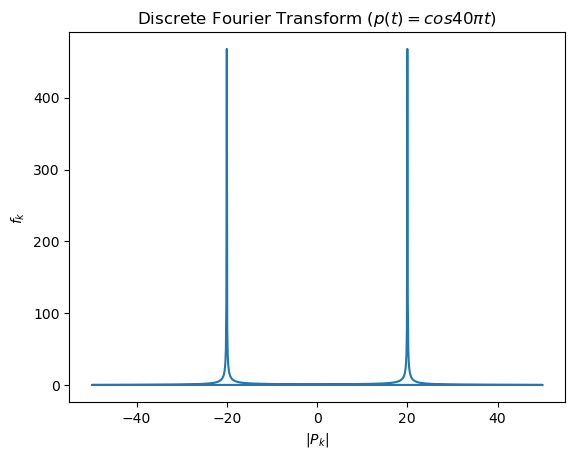

In [594]:
def p(t):
    return np.cos(40*np.pi*t)

ts = np.linspace(0, 10, int(10/.01))
xs = np.zeros(len(ts))
for i in range(len(ts)):
    xs[i] = p(ts[i])

Fs, Ps = fourier(xs, .01)
plt.plot(Fs, np.abs(Ps))
plt.title(r'Discrete Fourier Transform ($p(t)=cos40\pi t$)')
plt.ylabel(r'$f_k$')
plt.xlabel(r'|$P_k$|')
plt.show()

The graph has two peaks at $-f_{max} = -20$ and $f_{max} = 20$, and they peak at $f_k = 500$. This comes from the generic function $x(t) = Acos(\omega t) + Bsin(\omega t)$ where $\omega =  1$ compared to the discrete fourier transform equation for simple sinusoidal functions: $p(t) = Acos(2\pi \bar f t + \phi)$ $ \rightarrow \bar f = \pm \frac{1}{2\pi},$ Amplitude $= \frac{AN}{2}$

### Timing

<font color = blue>

Construct a function that takes as input the value $N$ and outputs the time required to find the Fourier transform of the function $p(t) = \cos 40\pi t$ on the interval $[0, 10]$, with $\Delta t = \frac{T}{N}$.  Use this function to create lists of the form $[N]$ and $[T_N]$, for $N = 50, 100, 150, 200, \dots, 1000$, and plot the results.

In a **discussion** identify what the time-scaling behavior you see in the plot is, and explain its algorirhmic origin.

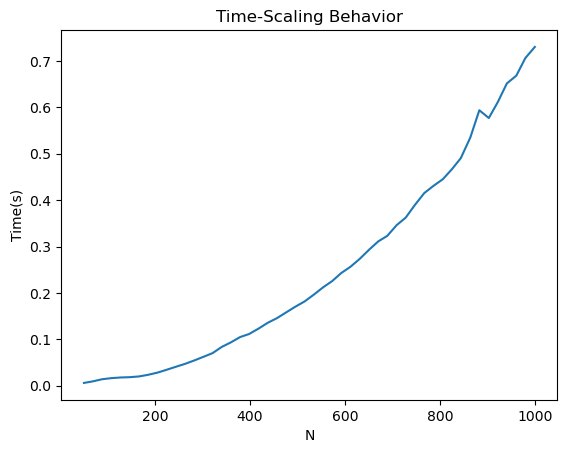

In [677]:
def p(t):
    return np.cos(40*np.pi*t)
    
def timing(N):
    times = np.zeros(len(N))
    for i in range(len(N)):
        ts = np.linspace(0, 10, int(N[i]))
        xs = np.array([p(t) for t in ts])
        del_t = 10 / N[i]
        start = time.time()
        fourier(xs, del_t)
        end = time.time()
        times[i] = end - start
    return N, times
    
Ns= np.linspace(50,1000, 50, dtype =int)
N, times = timing(N)

plt.plot(N, times)
plt.xlabel('N')
plt.ylabel('Time(s)')
plt.title('Time-Scaling Behavior')
plt.show()

The time scaling seems to be quadratic, meaning that the larger the data set, the more time it takes for the fourier function to run. This is as expected. 

## * Another Look at the Relativistic Harmonic Oscillator

<font color = blue>
    
The fact that the relativistic harmonic oscillator has sinusoidal oscillations for small amplitudes, but roughly triangular oscillations for large amplitudes makes it particularly interesting to examine using a Fourier transform.  Recall that the relativistic oscillator satisfies the differential equation (after appropriate non-dimensionalization)

$$
\ddot{x} = -x(1 - \dot{x}^2)^{3/2}
$$

Use RK4 to generate solutions to this equation (originally you used Verlet, but this will be more accurate), with 1000 time steps of size $\Delta t = 0.1$, where the object is released from rest with initial positions {0.1, 0.5, 1.0, and 5.0}.  Take the Fourier transform of each solution, and create a separate plot of the *power spectrum* for each solution.  (It may be best to use a logarithmic scale so as to see peaks of very different sizes clearly.)

Spend some time augmenting the plots: for the smaller amplitude cases show where the non-relativistic frequency peaks would be, and what heights they would be.  For the larger amplitude cases (where comparison with the SHO is less useful), label where the peaks actually are.  **Discuss** the results thoroughly.

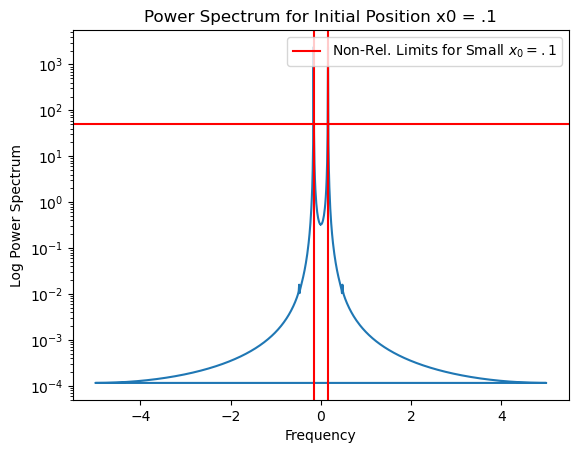

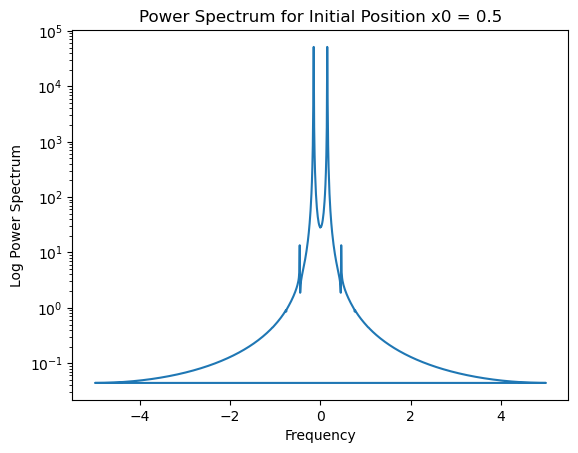

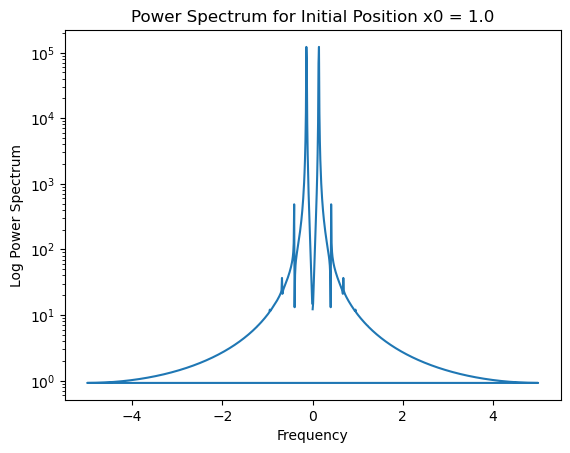

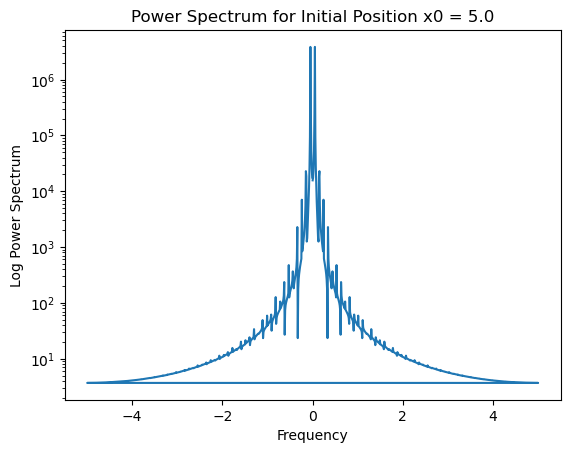

In [765]:
def RK4(F, x_initial, time_step, n):
    ts = np.zeros((n+1,)) + 0
    xs = np.array([x_initial] * (n+1))
    for i in range(n):
        k1 = F(xs[i], ts[i]) * time_step
        k2 = F(xs[i] + (k1/2), ts[i] + (time_step/2)) * time_step
        k3 = F(xs[i] + (k2/2), ts[i] + (time_step/2)) * time_step
        k4 = F(xs[i] + k3, ts[i] + time_step) * time_step
        xs[i+1] = xs[i] + ((k1 + (2*k2) + (2*k3) + k4)/6)
        ts[i+1] = ts[i] + time_step
    return ts, xs

def RSHO(state, t):
    x, v = state
    dxdt = v
    dvdt = -x * (1 - v**2)**(3/2)
    return np.array([dxdt, dvdt])
    
time_step = 0.1
n_steps = 1000
initial_positions = [0.5, 1.0, 5.0]

# first case
x_initial = np.array([.1, 0.0])
ts, x_t_full = RK4(RSHO, x_initial, time_step, n_steps)
x_t = x_t_full[:, 0] # extract only position

freqs, P_k = fourier(x_t, time_step)
power_spectrum = np.abs(P_k)**2 

plt.plot(freqs, power_spectrum)

plt.axhline(y = (.1 * n_steps) / 2, color = 'r', label = r'Non-Rel. Limits for Small $x_0=.1$')
plt.axvline(x = 1/(2*np.pi), color = 'r')
plt.axvline(x = -1/(2*np.pi), color = 'r')
plt.xlabel("Frequency")
plt.ylabel("Log Power Spectrum")
plt.title(f"Power Spectrum for Initial Position x0 = .1")
plt.yscale('log')
plt.legend()
plt.show()

for x0 in initial_positions:
    x_initial = np.array([x0, 0.0])
    ts, x_t_full = RK4(RSHO, x_initial, time_step, n_steps)
    x_t = x_t_full[:, 0] # extract only position

    freqs, P_k = fourier(x_t, time_step)
    power_spectrum = np.abs(P_k)**2 

    plt.plot(freqs, power_spectrum)
    plt.yscale('log')
    plt.xlabel("Frequency")
    plt.ylabel("Log Power Spectrum")
    plt.title(f"Power Spectrum for Initial Position x0 = {x0}")
    plt.show()

The non-relativistic limits come from the generic function $x(t) = Acos(\omega t) + Bsin(\omega t)$ where $\omega =  1$ compared to the discrete fourier transform equation for simple sinusoidal functions: $p(t) = Acos(2\pi \bar f t + \phi)$ $ \rightarrow \bar f = \pm \frac{1}{2\pi},$ Amplitude $= \frac{AN}{2}$. The plots show the power spectrum of a relativistic simple harmonic oscillator as the initial position increases. We can see that as it increases the power spectrum maximum increases as well, while frequency remains the same. 

## Final Project Work

<font color = blue>
This week, you should submit your progress on your final project, in a separate Python notebook.  Your notebook should be organized the same way these assignments are (broken into sections, code correctly commented, and short discussions after each section.)  Keep in mind that depending on the topic of your project, I may have very little experience with it, which means your discussions need to be that much better!

At the end, include a brief discussion of what you *intended* to accomplish as compared with what you *did* accomplish, as well as a plan of what you intend to do in the following week.